In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import scipy.spatial
import scipy.linalg
import scipy as sp
from scipy import signal
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp as smm
import statsmodels.tsa.stattools as tsa
import statsmodels.tsa.arima_model as arima
from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.pyplot as plt
import seaborn as sns
current_palette = sns.color_palette("hls", 8)
sns.set_palette(current_palette)

In [3]:
# Load the data
# wget ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
nc = xr.open_dataset('data/G10010_SIBT1850_v1.1.nc')

In [4]:
# Average out years
yr_avg = nc.seaice_conc.groupby('time.year').mean()

# Separate into seasons
seasons = nc.seaice_conc.groupby('time.season').mean('latitude').mean('longitude')
seas_df = seasons.to_dataframe()
seas_df = seas_df.groupby([lambda x: x.year, 'season']).mean()
seas_df = seas_df.reset_index()

djf_df = seas_df.loc[seas_df['season'] == 'DJF']
jja_df = seas_df.loc[seas_df['season'] == 'JJA']
mam_df = seas_df.loc[seas_df['season'] == 'MAM']
son_df = seas_df.loc[seas_df['season'] == 'SON']

djf_df.reset_index(inplace=True)
jja_df.reset_index(inplace=True)
mam_df.reset_index(inplace=True)
son_df.reset_index(inplace=True)

del djf_df['index']
del jja_df['index']
del mam_df['index']
del son_df['index']

djf_df.columns = ['year', 'season', 'seaice_conc']
jja_df.columns = ['year', 'season', 'seaice_conc']
mam_df.columns = ['year', 'season', 'seaice_conc']
son_df.columns = ['year', 'season', 'seaice_conc']

del djf_df['season']
del jja_df['season']
del mam_df['season']
del son_df['season']

In [5]:
seasons = ['JJA', 'SON', 'DJF', 'MAM']
dfs = {'DJF': djf_df, 'JJA': jja_df, 'MAM': mam_df, 'SON': son_df}

In [6]:
cmap = {'JJA': 'crimson', 'SON': 'darkorange', 'DJF': 'steelblue', 'MAM': 'seagreen'}

## Arctic splines

Since the arctic sea data set is such a long time series, we'll compute linear splines to get a piecewise trend of the data.

#### Definitions:

* A **linear spline** is a continuous function formed by connecting linear
segments.  The points where the segments connect are called the
**knots** of the spline.

* A **spline of degree** $D$ is a function formed by connecting polynomial segments
of degree $D$ so that:
    * the function is continuous,
    * the function has $D-1$ continuous derivatives,
    * the $D^{\text{th}}$ derivative is constant between knots

* The **truncated polynomial** of degree $D$ associated with knot $\xi_{k}$ is the function which is equal to $0$ to the left of $\xi_{k}$ and equal to $(x-\xi_{k})^D$ to the right of $\xi_{k}$.

$$(x-\xi_{k})_{+}^D = 
\begin{cases}
(x-\xi_{k})^D, & \text{if $x \geq \xi_{k}$} \\
0, & \text{if $x \lt \xi_{k}$}
\end{cases}
$$


#### Equation of spline of degree $D=1$ and $K$ knots:

$$y = \beta_{0} + \beta_{1}x + \sum_{k=1}^{K}b_{k}(x-\xi_{k})_{+}$$

#### Design Matrix:
$$
\mathbf{X} = 
\begin{bmatrix}
1 & x_1 & (x_{1}-\xi_{1})_{+} & \dots & (x_{1}-\xi_{K})_{+} \\
1 & x_2 & (x_{2}-\xi_{1})_{+} & \dots & (x_{2}-\xi_{K})_{+} \\
\vdots & \vdots  & \vdots & \ddots & \vdots \\
1 & x_n  & (x_{n}-\xi_{1})_{+} & \dots & (x_{n}-\xi_{K})_{+}
\end{bmatrix}
$$

In [7]:
def linear_splines(data, knots, degree=1):
    minyr = data.year.min()
    nyrs = data.year.shape[0]

    # Use indices of years for knots
    minyr = data.year.min()
    knots2 = [k-minyr for k in knots]
    
    # Column vector for beta1 are (t1, t2,...,tn)
    X1 = np.arange(nyrs)
    X1 = X1[:, np.newaxis]
    
    # Generate design matrix
    X2 = np.zeros((nyrs, len(knots2)))
    for col, k in enumerate(knots2):
        X2[k:, col] = np.abs(X2[k:, col] - X1[:nyrs-k, 0])
    X = np.hstack((X1, X2))
    return smf.glm('seaice_conc ~ X', data=data).fit()

### Knots for Arctic sea

From the explore_seaice notebook, the trends look peicewise with possible knots at various locations. We'll define our set of knots for each season:

$$
K_{\text{JJA}} = \{1917, 1944, 1996\}\\
K_{\text{SON}} = \{1917, 1943, 1996\}\\
K_{\text{DJF}} = \{1974, 1996\}\\
K_{\text{MAM}} = \{1933, 1979\}
$$

We'll plot the knots to visually check

In [8]:
# Define the knots
jjaknots = [1917, 1944, 1997]
#jjaknots2 = [1893, 1899, 1917, 1943, 1996]
sonknots = [1917, 1943, 1997]
djfknots = [1974, 1997]
mamknots = [1933, 1979, 1997]

splines = {'JJA': linear_splines(jja_df, jjaknots),
           'SON': linear_splines(son_df, sonknots),
           'DJF': linear_splines(djf_df, djfknots),
           'MAM': linear_splines(mam_df, mamknots)}

In [9]:
def plot_splines(yrs, conc, preds, label, season=None, ax=None, col='g'):
    if ax is None:
        ax = plt.gca()
    spl = ax.plot(yrs, conc, label='seaice conc', color='silver')
    ax.plot(yrs, preds, label=label, color=col)
    ax.legend(loc="upper left")
    ax.set_xlim(1845, 2016)
    #ax.set_ylim(17.5, 26)
    ax.set_xlabel(r'Year', fontsize=14)
    ax.set_ylabel(r'Sea Ice Concentration [\%]', fontsize=14)
    title = 'Linear Splines for {}'.format(season)
    ax.set_title(r'\textbf{' + title + '}', fontsize=16)
    ax.annotate('1997', xy=(147,24), xytext=(3, 1.5))
    #ax.annotate()
    return spl

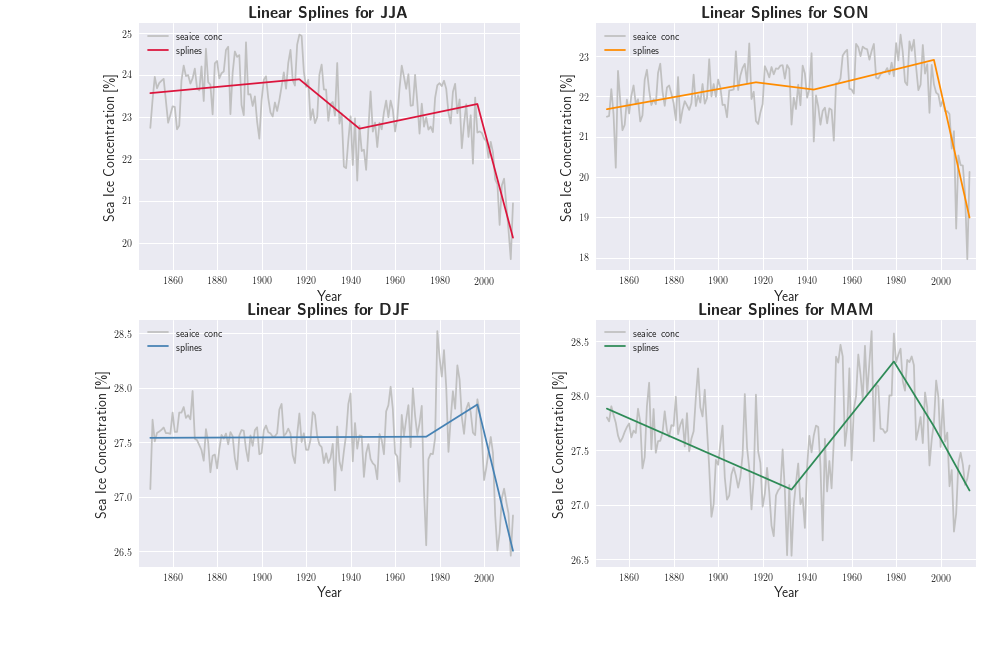

In [10]:
f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines[s].fittedvalues
    plot_splines(yr, conc, preds, 'splines', season=s, ax=ax, col=cmap[s])
    


Visually the splines look reasonable. However, let's test the significance of each spline and remove the splines that are not significicant with a significance level, $\alpha = 0.05$

We'll use Bonferroni's correction for multiple tests.

In [11]:
#splines['JJA'].summary()

In [12]:
#f = splines['JJA']

In [13]:
#f.resid_response.values

In [14]:
nyrs = yr_avg.shape[0]
#nparams = len(knots) + 2

# Estimates
mu_hat = {season: spl.mu for season, spl in splines.items()}
R = {season: spl.resid_response.values for season, spl in splines.items()}
cov = {season: spl.cov_params() for season, spl in splines.items()}
#sigma_hat2 = {season: np.sum(r**2) / (nyrs-nparams) for season, r in R.items()}
pvals = {season: spl.pvalues.values for season, spl in splines.items()}

In [15]:
bonferonnis = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals.items()}

In [16]:
for season, test in bonferonnis.items():
    print('{}: {}'.format(season, test[0]))

JJA: [ True False  True  True  True]
SON: [ True  True False False  True]
DJF: [ True False  True  True]
MAM: [ True  True  True  True False]


We see some splines are not significant. We'll remove those and recompute our model. Our new knots are now:

$$
K_{\text{JJA}} = \{1944, 1996\}\\
K_{\text{SON}} = \{1917, 1996\}\\
K_{\text{DJF}} = \{1996\}\\
K_{\text{MAM}} = \{1933, 1979\}
$$


In [17]:
# Splines with new knots... Pt.2
jjaknots2 = [1944, 1996]
sonknots2 = [1917, 1996]
djfknots2 = [1996]
mamknots2 = [1933, 1979]

splines2 = {'JJA': linear_splines(jja_df, jjaknots2),
           'SON': linear_splines(son_df, sonknots2),
           'DJF': linear_splines(djf_df, djfknots2),
           'MAM': linear_splines(mam_df, mamknots2)}

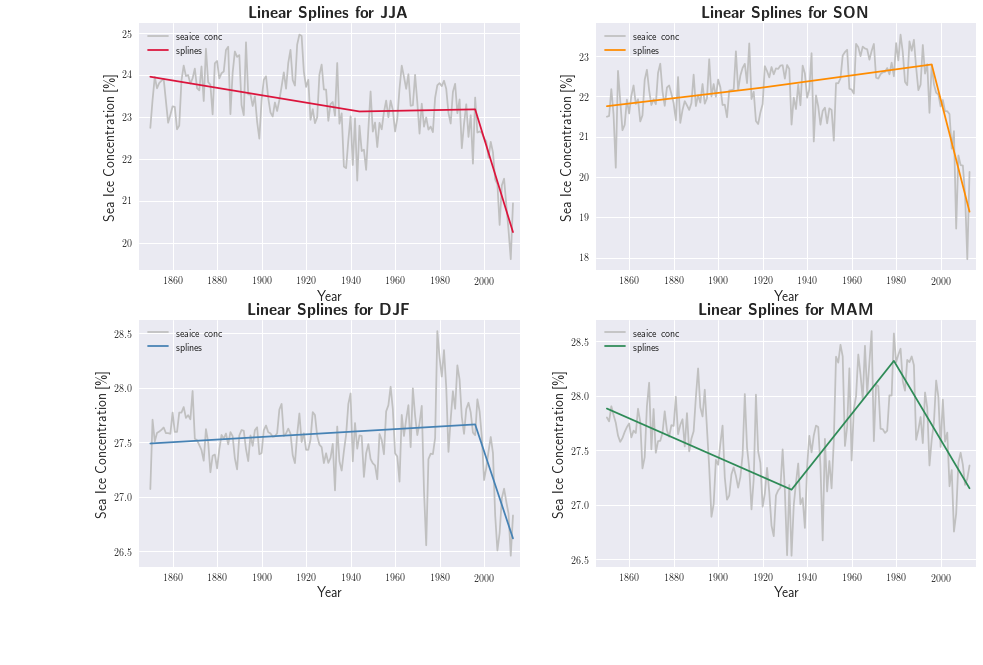

In [18]:
f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines2[s].fittedvalues
    plot_splines(yr, conc, preds, 'splines', season=s, ax=ax, col=cmap[s])

In [19]:
# Estimates Pt.2
mu_hat2 = {season: spl.mu for season, spl in splines2.items()}
R2 = {season: spl.resid_response.values for season, spl in splines2.items()}
cov2 = {season: spl.cov_params() for season, spl in splines2.items()}
pvals2 = {season: spl.pvalues.values for season, spl in splines2.items()}

bonferonnis2 = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals2.items()}

for season, test in bonferonnis2.items():
    print('{}: {}'.format(season, test[0]))

JJA: [ True  True False  True]
SON: [ True  True False  True]
DJF: [ True  True  True]
MAM: [ True  True  True  True]


Once again, we see some splines that don't make the cut. We'll remove those, and recompute our model. Our knots are now:

$$
K_{\text{JJA}} = \{1996\}\\
K_{\text{SON}} = \{1996\}\\
K_{\text{DJF}} = \{1996\}\\
K_{\text{MAM}} = \{1933, 1979\}
$$


In [20]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

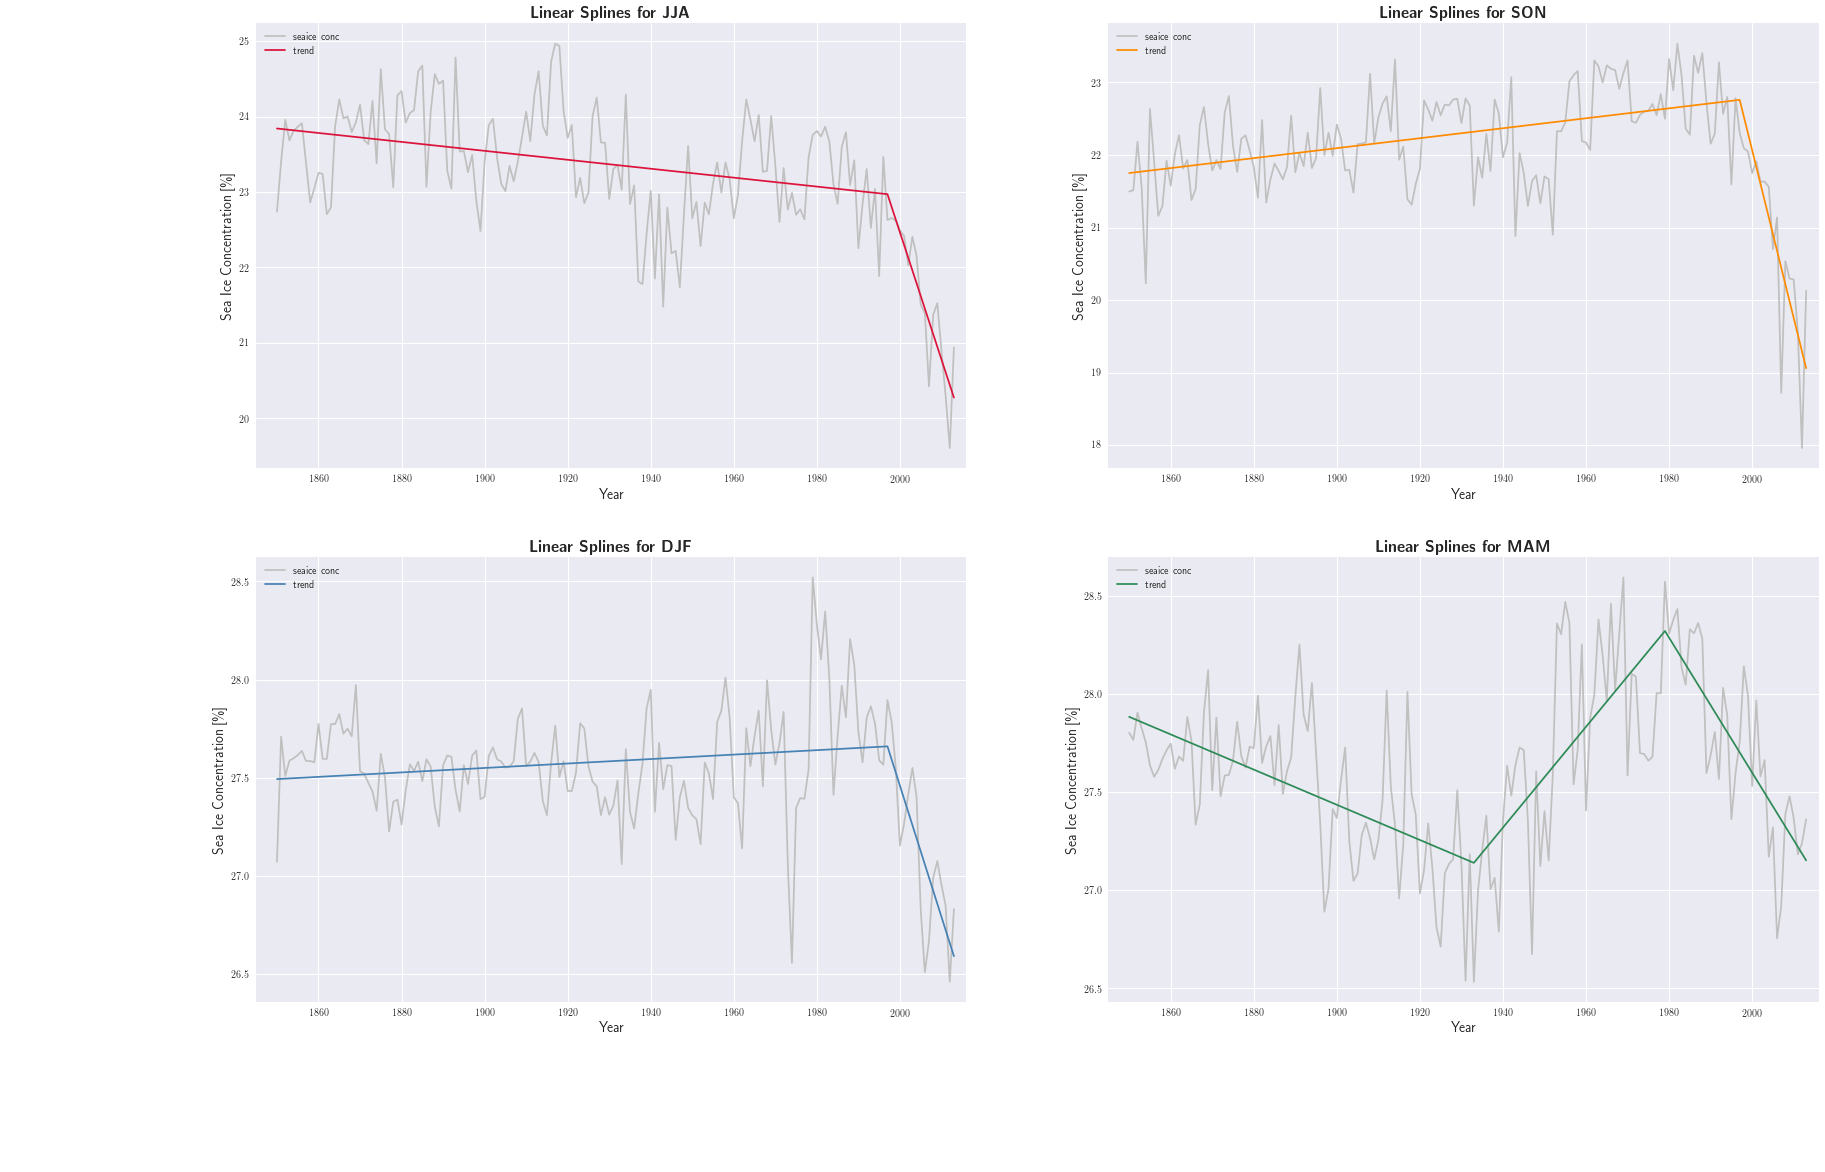

In [21]:
# Estimates Pt.3
jjaknots3 = [1997]
sonknots3 = [1997]
djfknots3 = [1997]
mamknots3 = [1933, 1979]

splines3 = {'JJA': linear_splines(jja_df, jjaknots3),
           'SON': linear_splines(son_df, sonknots3),
           'DJF': linear_splines(djf_df, djfknots3),
           'MAM': linear_splines(mam_df, mamknots3)}

f, axs = plt.subplots(2, 2, figsize=(28,18))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines3[s].fittedvalues
    plot_splines(yr, conc, preds, 'trend', season=s, ax=ax, col=cmap[s])

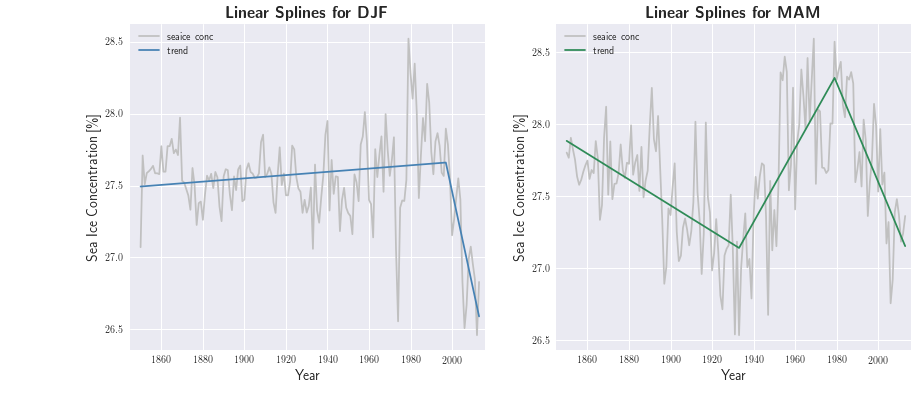

In [22]:
f, (ax1, ax2)= plt.subplots(1,2, figsize=(14,6))
plot_splines(dfs['DJF'].year, dfs['DJF'].seaice_conc,
                 splines3['DJF'].fittedvalues, 'trend', 'DJF', ax=ax1, col=cmap['DJF'])
plot_splines(dfs['MAM'].year, dfs['MAM'].seaice_conc,
                 splines3['MAM'].fittedvalues, 'trend', 'MAM', ax=ax2, col=cmap['MAM'])

#f.savefig('/home/hflores/pres_figs/winter_splines.png', format='png', 
#          dpi=600, bbox_inches='tight', transparent=True)

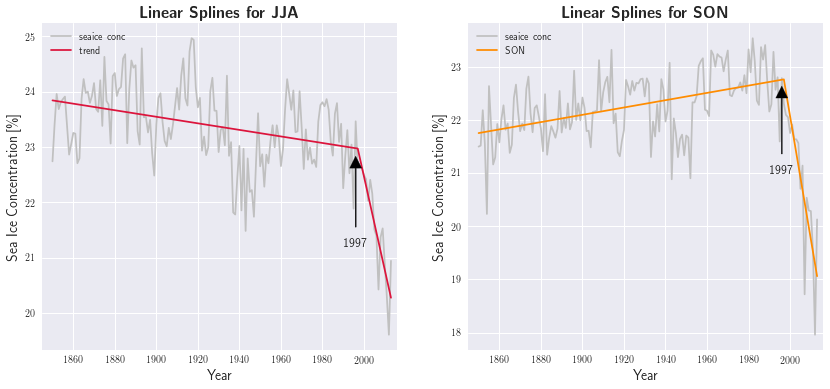

In [23]:
f, (ax1, ax2)= plt.subplots(1,2, figsize=(14,6))

ax1.plot(dfs['JJA'].year, dfs['JJA'].seaice_conc, label='seaice conc', color='silver')
ax1.plot(dfs['JJA'].year,splines3['JJA'].fittedvalues, label='trend', color=cmap['JJA'])
ax1.legend(loc="upper left")
ax1.set_xlim(1845, 2016)
#ax.set_ylim(17.5, 26)
ax1.set_xlabel(r'Year', fontsize=14)
ax1.set_ylabel(r'Sea Ice Concentration [\%]', fontsize=14)
title = 'Linear Splines for {}'.format('JJA')
ax1.set_title(r'\textbf{' + title + '}', fontsize=16)
ax1.annotate('1997', xy=(1996,23), xytext=(1996,21.2), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.1, width=1), 
             horizontalalignment='center')


ax2.plot(dfs['SON'].year, dfs['SON'].seaice_conc, label='seaice conc', color='silver')
ax2.plot(dfs['SON'].year,splines3['SON'].fittedvalues, label='SON', color=cmap['SON'])
ax2.legend(loc="upper left")
ax2.set_xlim(1845, 2016)
#ax.set_ylim(17.5, 26)
ax2.set_xlabel(r'Year', fontsize=14)
ax2.set_ylabel(r'Sea Ice Concentration [\%]', fontsize=14)
title = 'Linear Splines for {}'.format('SON')
ax2.set_title(r'\textbf{' + title + '}', fontsize=16)
ax2.annotate('1997', xy=(1996,22.8), xytext=(1996,21), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.1, width=1), 
             horizontalalignment='center')


In [24]:
# Bonferonnis Pt.3
mu_hat3 = {season: spl.mu for season, spl in splines3.items()}
R3 = {season: spl.resid_response.values for season, spl in splines3.items()}
cov3 = {season: spl.cov_params() for season, spl in splines3.items()}
pvals3 = {season: spl.pvalues.values for season, spl in splines3.items()}

bonferonnis3 = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals3.items()}

for season, test in bonferonnis3.items():
    print('{}: {}'.format(season, test[0]))

JJA: [ True  True  True]
SON: [ True  True  True]
DJF: [ True  True  True]
MAM: [ True  True  True  True]


Finally! We have a set of knots that are significant.

# Test our detrended series for stationarity

1. Plot our detrended series
2. Perform the Augmented Dickey-Fuller test 
    * Check p-values (if p-value is < 0.05, hence the data is staionary)

In [25]:
# Rename R3 to something more meaningful: residuals
residuals = R3

### 1. Plot detrended series

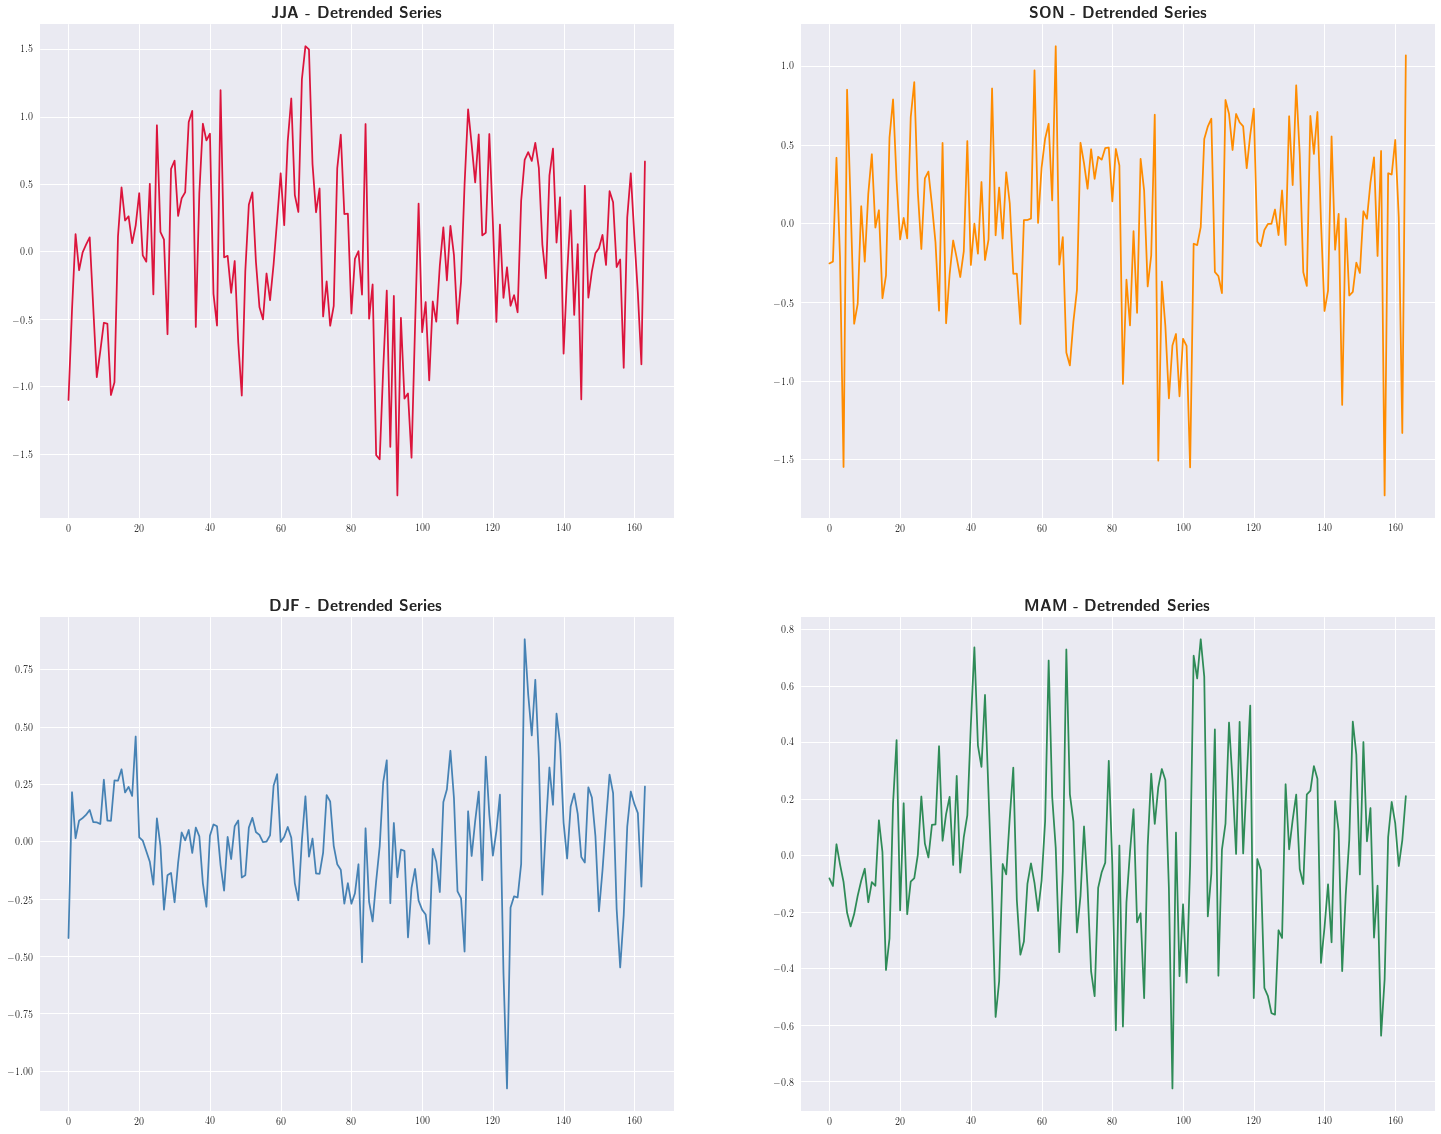

In [26]:
f, axs = plt.subplots(2, 2, figsize=(25,20))

axs[0,0].plot(residuals['JJA'], color=cmap['JJA'])
axs[0,0].set_title(r'\textbf{JJA - Detrended Series}', fontsize=16)


axs[0,1].plot(residuals['SON'], color=cmap['SON'])
axs[0,1].set_title(r'\textbf{SON - Detrended Series}', fontsize=16)


axs[1,0].plot(residuals['DJF'], color=cmap['DJF'])
axs[1,0].set_title(r'\textbf{DJF - Detrended Series}', fontsize=16)

axs[1,1].plot(residuals['MAM'], color=cmap['MAM'])
axs[1,1].set_title(r'\textbf{MAM - Detrended Series}', fontsize=16)


### 2. Augmented Dickey-Fuller test for stationarity

In [27]:
def test_stationarity(timeseries, label='Original', ax=None):
    if ax is None:
        ax = plt.gca()
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=15)
    rolstd = pd.rolling_std(timeseries, window=15)

    #Plot rolling statistics:
    orig = ax.plot(timeseries, color='k', alpha=0.3, label=label)
    mean = ax.plot(rolmean, color='darkred', label='Rolling Mean')
    std = ax.plot(rolstd, color='darkorange', label = 'Rolling Std')
    ax.legend(loc='best')
    ax.set_title('Rolling Mean & Standard Deviation')
    #ax.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = tsa.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/home/hflores/anaconda2/envs/arcticsea/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/hflores/anaconda2/envs/arcticsea/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


Results of Dickey-Fuller Test:
Test Statistic                -7.497911e+00
p-value                        4.330247e-11
#Lags Used                     0.000000e+00
Number of Observations Used    1.630000e+02
Critical Value (1%)           -3.471119e+00
Critical Value (5%)           -2.879441e+00
Critical Value (10%)          -2.576314e+00
dtype: float64


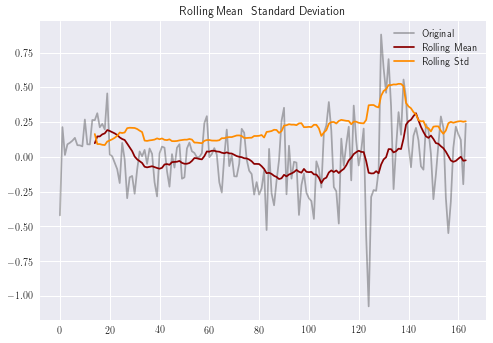

In [28]:
test_stationarity(residuals['DJF'])

In [29]:
# MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)
ad_pvalues = {season: tsa.adfuller(resid)[1] for season, resid in residuals.items()}

In [30]:
ad_pvalues

{'DJF': 4.3302468038508157e-11,
 'JJA': 0.023396880315144024,
 'MAM': 3.5523375397601975e-13,
 'SON': 6.1596541949563779e-09}

All p-values are < 0.05, hence the detrended series are staionary.

# Determine the type of model

We want to determine whether our model is AR(p), MA(q), ARIMA, etc...

1. Plot ACF and PACF of our detrended series
2. Look at the estimated power spectral density (smoothed periodogram) for periodicity
3. From the periodograms determine the frequency for our model.

### 1. Plot ACFs and PACFs of the residiuals (detrended series) for each season

In [31]:
def plot_corr(acf_x, nlags, ax=None, title='Autocorrelation', **kwargs):
    def bonferroni_confint(x, alpha=0.05):
        nobs = len(x)
        confint = sp.stats.norm.ppf(1 - alpha/nobs) / np.sqrt(nobs)
        return confint, -confint
    
    confint = bonferroni_confint(acf_x)
    
    if ax is None:
        ax = plt.gca()
    fig = ax.stem(acf_x)
    plt.setp(fig[0], 'markersize', 0)
    ax.set_title(r"\textbf{" + title + "}", fontsize=16)
    ax.set_ylim([min(acf_x)-0.3, 1])
    ax.set_xlabel(r"Lag", fontsize=14)
    
    if "pacf" in title.lower() or "partial" in title.lower():
        ax.set_ylabel(r"Partial ACF", fontsize=14)
    else:
        ax.set_ylabel(r"ACF", fontsize=14)

    if confint is not None:
        ax.axhline(y=confint[0],xmin=0,xmax=nlags,c='black',linewidth=0.5,linestyle='--',zorder=0)
        ax.axhline(y=confint[1],xmin=0,xmax=nlags,c='black',linewidth=0.5,linestyle='--',zorder=0)
    return fig

In [32]:
def plot_acf(data, nlags, alpha=0.05, ax=None, title='Autocorrelation'):
    acf_x, _ = tsa.acf(data, nlags=nlags, alpha=alpha)
    return plot_corr(acf_x, nlags=nlags, ax=ax, title=title)

In [33]:
def plot_pacf(data, nlags, alpha=0.05, ax=None, title='Partial Autocorrelation'):
    method = 'ywm'
    pacf_x, _ = tsa.pacf(data, nlags=nlags, alpha=alpha, method=method)
    return plot_corr(pacf_x, nlags=nlags, ax=ax, title=title)

In [34]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<Container object of 3 artists>

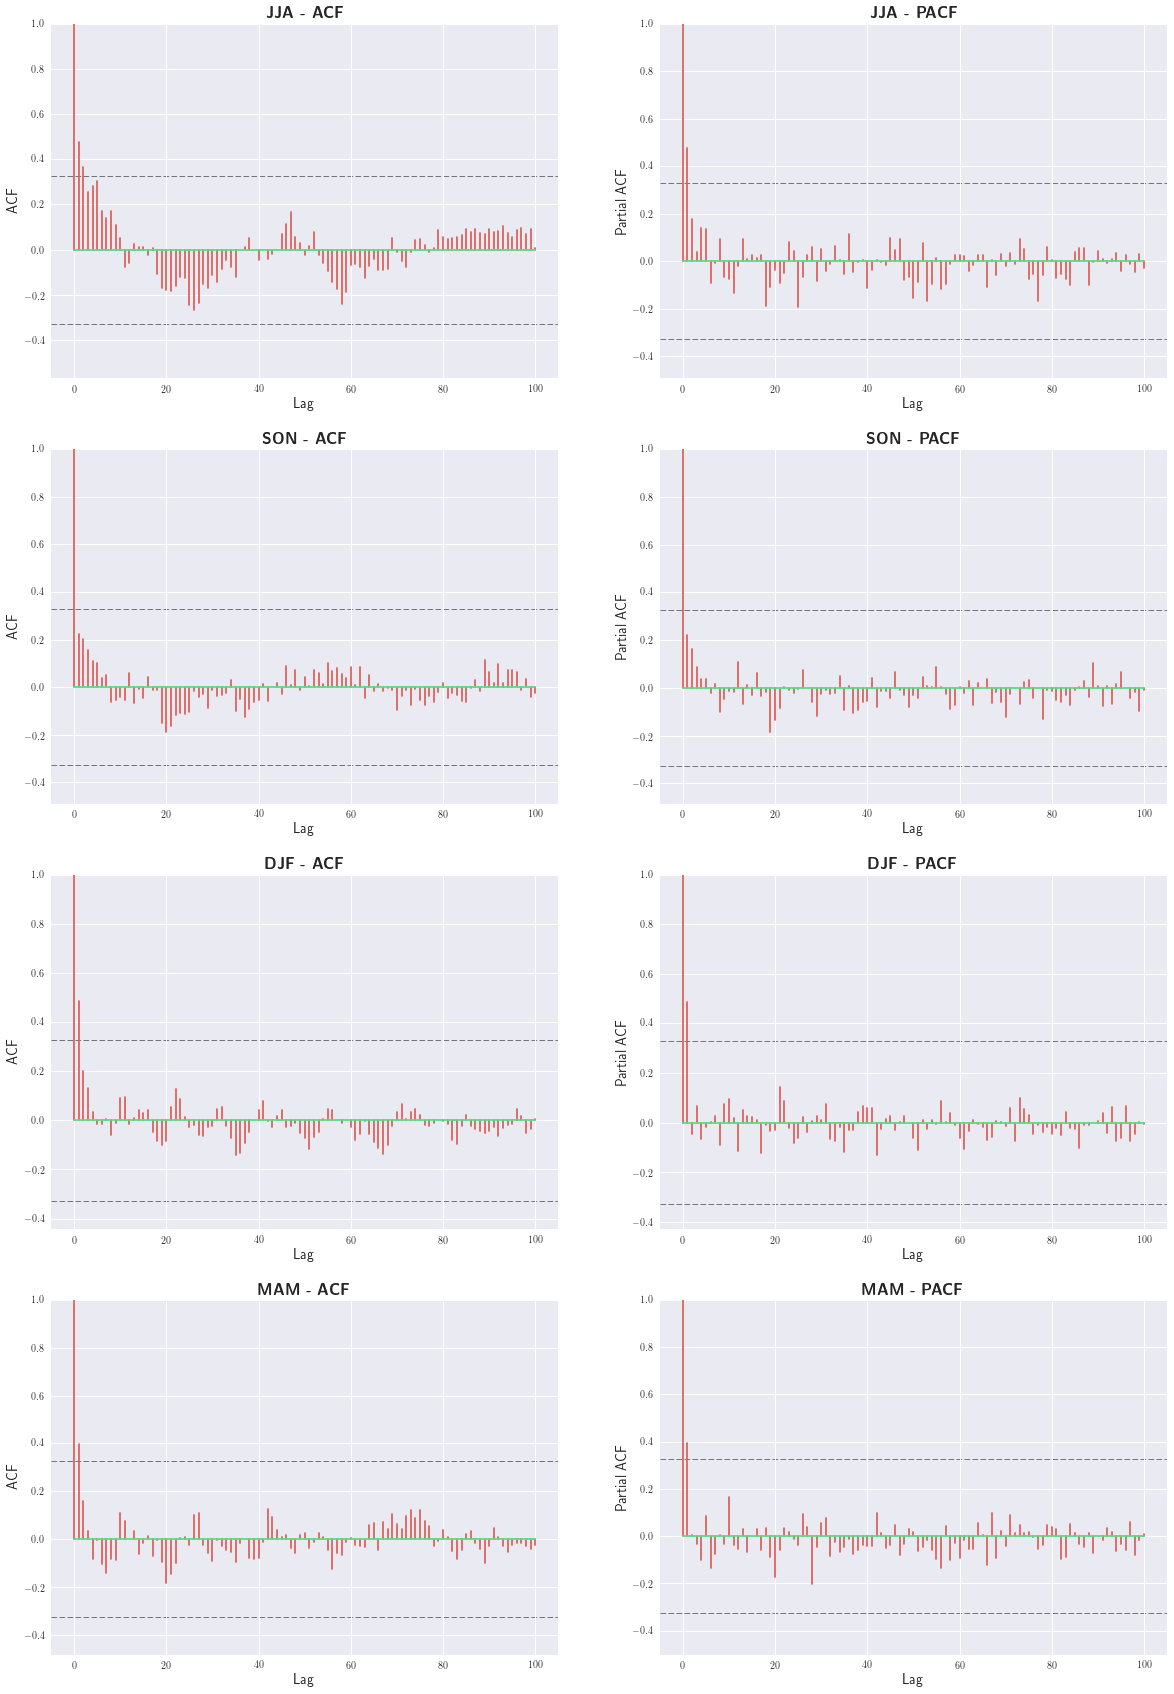

In [35]:
# Plot ACFs and PACFs
f, axs = plt.subplots(4, 2, figsize=(20,30))

plot_acf(residuals['JJA'], nlags=100, ax=axs[0,0], title='JJA - ACF')
plot_pacf(residuals['JJA'], nlags=100, ax=axs[0,1], title='JJA - PACF')

plot_acf(residuals['SON'], nlags=100, ax=axs[1,0], title='SON - ACF')
plot_pacf(residuals['SON'], nlags=100, ax=axs[1,1], title='SON - PACF')

plot_acf(residuals['DJF'], nlags=100, ax=axs[2,0], title='DJF - ACF')
plot_pacf(residuals['DJF'], nlags=100, ax=axs[2,1], title='DJF - PACF')

plot_acf(residuals['MAM'], nlags=100, ax=axs[3,0], title='MAM - ACF')
plot_pacf(residuals['MAM'], nlags=100, ax=axs[3,1], title='MAM - PACF')

In [36]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [37]:
# f, axr = plt.subplots(4, 2, figsize=(18,16))

# axr[0,0].scatter(jja_df.year, residuals['JJA'], color=cmap['JJA'])
# axr[0,0].set_ylabel('Residual')
# axr[0,0].set_title('JJA')
# axr[0,1].scatter(jja_df.seaice_conc, residuals['JJA'], color=cmap['JJA'])

# axr[1,0].scatter(son_df.year, residuals['SON'], color=cmap['SON'])
# axr[1,0].set_ylabel('Residual')
# axr[1,0].set_title('SON')
# axr[1,1].scatter(son_df.seaice_conc, residuals['SON'], color=cmap['SON'])

# axr[2,0].scatter(djf_df.year, residuals['DJF'], color=cmap['DJF'])
# axr[2,0].set_ylabel('Residual')
# axr[2,0].set_title('DJF')
# axr[2,1].scatter(djf_df.seaice_conc, residuals['DJF'], color=cmap['DJF'])

# axr[3,0].scatter(mam_df.year, residuals['MAM'], color=cmap['MAM'])
# axr[3,0].set_ylabel('Residual')
# axr[3,0].set_title('MAM')
# axr[3,1].scatter(mam_df.seaice_conc, residuals['MAM'], color=cmap['MAM'])

# axr[3,0].set_xlabel('Years')
# axr[3,1].set_xlabel('Seaice Concentration')

### 2. Spectral Density Estimation via Welch's method

In [38]:
# Compute FFT of the residuals
# Take the periodogram (abs(R)^2)
# Plot the periodogram

In [39]:
#ffts = {season: np.fft.fft(resid) for season, resid in residuals.items()}
#periodograms = {season: np.abs(fftr)**2 for season, fftr in ffts.items()}
periodograms = {season: signal.welch(resid, window='hann')[1] for season, resid in residuals.items()}

/home/hflores/anaconda2/envs/arcticsea/lib/python3.6/site-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 164, using nperseg = 164
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))


In [40]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

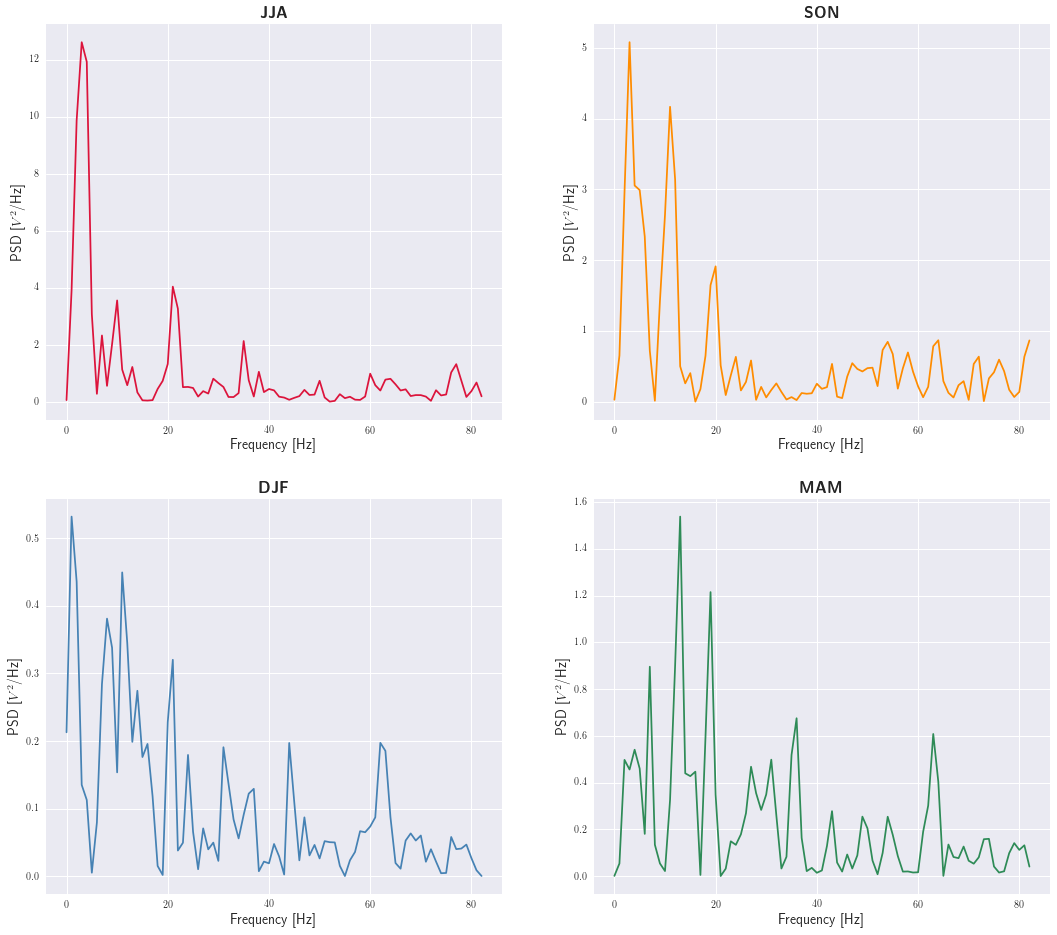

In [41]:
f, ax = plt.subplots(2, 2, figsize=(18,16))

ax[0,0].plot(periodograms['JJA'], color=cmap['JJA'])
ax[0,0].set_title(r'\textbf{JJA}', fontsize=16)
ax[0,0].set_xlabel(r'Frequency [Hz]', fontsize=14)
ax[0,0].set_ylabel(r'PSD [$V^2$/Hz]', fontsize=14)

ax[0,1].plot(periodograms['SON'], color=cmap['SON'])
#ax[0,1].set_title('SON')
ax[0,1].set_title(r'\textbf{SON}', fontsize=16)
ax[0,1].set_xlabel(r'Frequency [Hz]', fontsize=14)
ax[0,1].set_ylabel(r'PSD [$V^2$/Hz]', fontsize=14)

ax[1,0].plot(periodograms['DJF'], color=cmap['DJF'])
#ax[1,0].set_title('DJF')
ax[1,0].set_title(r'\textbf{DJF}', fontsize=16)
ax[1,0].set_xlabel(r'Frequency [Hz]', fontsize=14)
ax[1,0].set_ylabel(r'PSD [$V^2$/Hz]', fontsize=14)

ax[1,1].plot(periodograms['MAM'], color=cmap['MAM'])
#ax[1,1].set_title('MAM')
ax[1,1].set_title(r'\textbf{MAM}', fontsize=16)
ax[1,1].set_xlabel(r'Frequency [Hz]', fontsize=14)
ax[1,1].set_ylabel(r'PSD [$V^2$/Hz]', fontsize=14)

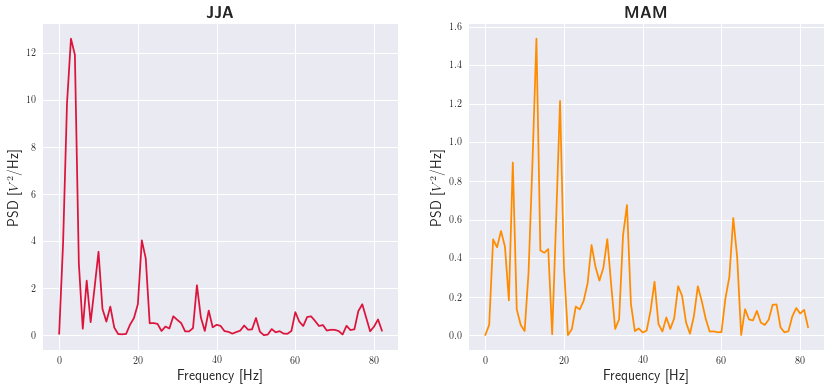

In [42]:
f, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].plot(periodograms['JJA'][:], color=cmap['JJA'])
ax[0].set_title(r'\textbf{JJA}', fontsize=16)
ax[0].set_xlabel(r'Frequency [Hz]', fontsize=14)
ax[0].set_ylabel(r'PSD [$V^2$/Hz]', fontsize=14)

ax[1].plot(periodograms['MAM'][:], color=cmap['SON'])
ax[1].set_title(r'\textbf{MAM}', fontsize=16)
ax[1].set_xlabel(r'Frequency [Hz]', fontsize=14)
ax[1].set_ylabel(r'PSD [$V^2$/Hz]', fontsize=14)

#f.savefig('/home/hflores/repos/kaust_presentation/winter_psd.eps', format='eps', 
#          dpi=1200, bbox_inches='tight')

### 3. Get peaks to determine the frequency

In [43]:
freqs = {season: np.argmax(psd) for season, psd in periodograms.items()}
freqs

{'DJF': 1, 'JJA': 3, 'MAM': 13, 'SON': 3}

In [44]:
periodograms['MAM'][36]

0.67550610640228503

In [45]:
t1 = yr_avg.year.values
nyrs = t1.max() - t1.min() + 1

# JJA

In [46]:
y_jja = jja_df.seaice_conc.values
sin3_jja = np.array([np.sin(2*np.pi* freqs['JJA'] * (t/nyrs)) for t in np.arange(nyrs)])
cos3_jja = np.array([np.cos(2*np.pi* freqs['JJA'] * (t/nyrs)) for t in np.arange(nyrs)])

sin7_jja = np.array([np.sin(2*np.pi* 7 * (t/nyrs)) for t in np.arange(nyrs)])
cos7_jja = np.array([np.cos(2*np.pi* 7 * (t/nyrs)) for t in np.arange(nyrs)])

sin10_jja = np.array([np.sin(2*np.pi* 10 * (t/nyrs)) for t in np.arange(nyrs)])
cos10_jja = np.array([np.cos(2*np.pi* 10 * (t/nyrs)) for t in np.arange(nyrs)])

sin21_jja = np.array([np.sin(2*np.pi* 21 * (t/nyrs)) for t in np.arange(nyrs)])
cos21_jja = np.array([np.cos(2*np.pi* 21 * (t/nyrs)) for t in np.arange(nyrs)])

sin35_jja = np.array([np.sin(2*np.pi* 35 * (t/nyrs)) for t in np.arange(nyrs)])
cos35_jja = np.array([np.cos(2*np.pi* 35 * (t/nyrs)) for t in np.arange(nyrs)])

In [47]:
fit_jja = smf.glm(
    'y_jja ~ sin3_jja + cos3_jja + \
    sin7_jja + cos7_jja + \
    sin10_jja + cos10_jja + \
    sin21_jja + cos21_jja +\
    sin35_jja + cos35_jja',data=jja_df).fit()
fit_jja.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  y_jja   No. Observations:                  164
Model:                            GLM   Df Residuals:                      153
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                  0.635891699548
Method:                          IRLS   Log-Likelihood:                -189.89
Date:                Sun, 23 Jul 2017   Deviance:                       97.291
Time:                        20:04:27   Pearson chi2:                     97.3
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.2248      0.062    372.977      0.000      23.103      23.347
sin3_jja       0.4793      0.088      5.442      0.000       0.307       0.652
cos3_jja      -0.2512      0.088     -2.852      0.004      -0.424      -0.079
sin7_jja       0.0097      0.088      0.110      0.913      -0.163       0.182
cos7_jja      -0.0649      0.088     -0.737      0.461      -0.238       0.108
sin10_jja      0.2097      0.088      2.381      0.017       0.037       0.382
cos10_jja      0.2092      0.088      2.375      0.018       0.037       0.382
sin21_jja     -0.1102      0.088     -1.251      0.211      -0.283       0.062
cos21_jja     -0.0379      0.088     -0.431      0.667      -0.211       0.135
sin35_jja      0.2036      0.088      2.312      0.021       0.031       0.376
cos35_jja      0.0366      0.088      0.415      0.678      -0.136       0.209
==============================================================================
"""

**NOTE: sine and cosine are significant**

In [48]:
print(fit_jja.params)
k_hat_jja = fit_jja.params.values  # extract fitted regression coefficients
e_jja = fit_jja.resid_response    # extract raw residuals

Intercept    23.224777
sin3_jja      0.479261
cos3_jja     -0.251151
sin7_jja      0.009650
cos7_jja     -0.064933
sin10_jja     0.209685
cos10_jja     0.209178
sin21_jja    -0.110174
cos21_jja    -0.037950
sin35_jja     0.203577
cos35_jja     0.036577
dtype: float64


In [49]:
# Check to see if the mean of residuals are numerically close to 0
print(np.mean(e_jja))

4.6358580930689465e-15


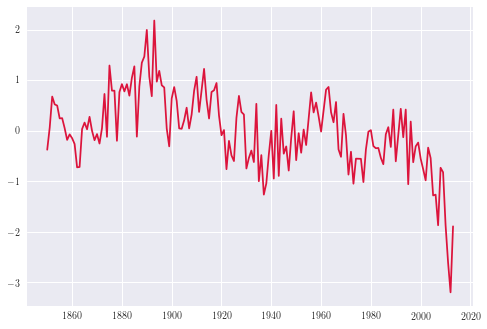

In [50]:
plt.plot(jja_df.year, e_jja, color=cmap['JJA'])

### Fit seasonal cycle with significant terms (sine and cosine)

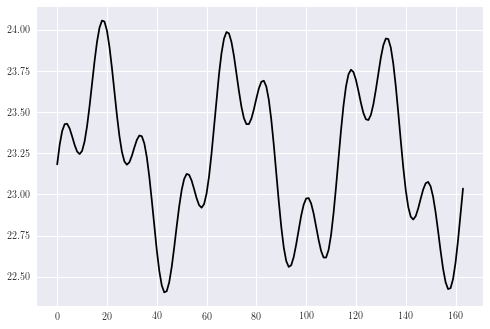

In [51]:
# fitted seasonal cycle
f_hat_jja = k_hat_jja[0] + k_hat_jja[1]*sin3_jja + k_hat_jja[2]*cos3_jja +\
            k_hat_jja[5]*sin10_jja + k_hat_jja[6]*cos10_jja
plt.plot(f_hat_jja,'k-') 

In [52]:
# Remove residuals and subtract mean for second order residuals: R^2
resid2_jja = residuals['JJA'] - f_hat_jja
resid2_jja = resid2_jja - np.mean(resid2_jja)

<Container object of 3 artists>

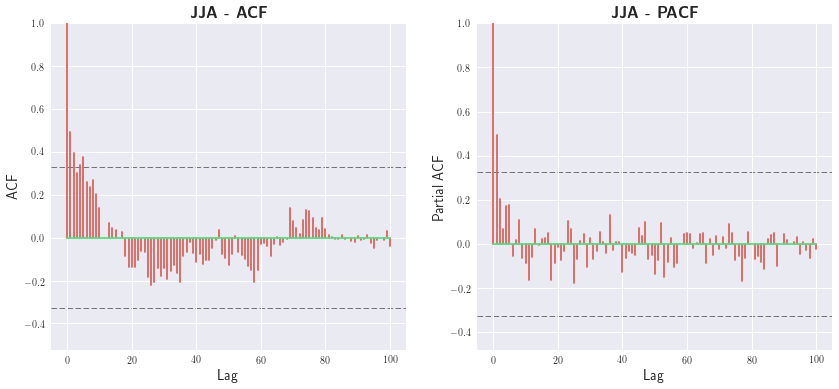

In [54]:
f, axs = plt.subplots(1, 2, figsize=(14,6))

plot_acf(resid2_jja, nlags=100, ax=axs[0], title='JJA - ACF')
plot_pacf(resid2_jja, nlags=100, ax=axs[1], title='JJA - PACF')

#f.savefig('/home/hflores/repos/kaust_presentation/jja_acf.eps', format='eps', 
#          dpi=1200, bbox_inches='tight')

In [55]:
# Fit AR1 & AR2 model
fit_jja_ar1 = arima.ARIMA(resid2_jja, (1,0,0)).fit()
fit_jja_ar2 = arima.ARIMA(resid2_jja, (2,0,0)).fit()
print(fit_jja_ar1.summary())
print(fit_jja_ar2.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(1, 0)   Log Likelihood                -133.701
Method:                       css-mle   S.D. of innovations              0.546
Date:                Sun, 23 Jul 2017   AIC                            273.401
Time:                        20:04:51   BIC                            282.701
Sample:                             0   HQIC                           277.176
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.085     -0.015      0.988      -0.168       0.166
ar.L1.y        0.5029      0.068      7.362      0.000       0.369       0.637
                                    Roots           

**NOTE: Choose AR(2) since it has lower AIC and BIC**

In [56]:
def ts_diagnostics(fit, title='Season', save=None):
    # Removes fitted terms from residuals
    def ar_residuals(fit):
        resids = fit.resid
        phi_hat = fit.arparams
        X1 = resids[1:]
        X2 = resids[:-1]
        
        # Make column vector
        X1 = X1[:,np.newaxis]
        X2 = X2[:,np.newaxis]
        
        X = np.hstack((X1, X2))
        e_ar = resids[1:] - np.dot(X, phi_hat)
        return e_ar
    
    e_ar = ar_residuals(fit)
    x = np.arange(len(e_ar))
    
    import matplotlib.gridspec as gridspec
    f = plt.figure(figsize=(25,12))
    gs = gridspec.GridSpec(2, 3)
    ax1 = plt.subplot(gs[:, 0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[0,2])
    ax4 = plt.subplot(gs[1,1])
    ax5 = plt.subplot(gs[1,2])
    
    ax1.scatter(x, e_ar)
    r"\textbf{" + title + "}"
    ax1.set_title(r'\textbf{' + title + ' Residuals}', fontsize=16)
    plot_acf(e_ar, nlags=len(e_ar)-1, ax=ax2)
    plot_pacf(e_ar, nlags=len(e_ar)-1, ax=ax3)
    ax4.scatter(list(range(1,11)), ljungbox(e_ar, 10)[1])
    ax4.set_title(r'\textbf{P-values for Ljung-Box statistic}', fontsize=16)
    stats.probplot(e_ar, dist="norm", plot=ax5)
    ax5.set_title(r'\textbf{QQ Plot of Residuals}', fontsize=16)
    ax5.set_xlabel(r'Theoretical quantiles', fontsize=14)
    ax5.set_ylabel(r'Ordered Values', fontsize=14)
    
    if save:
        fname = '/home/hflores/repos/kaust_presentation/{}.eps'.format(save)
        f.savefig(fname, format='eps', dpi=1200, bbox_inches='tight')
    return e_ar

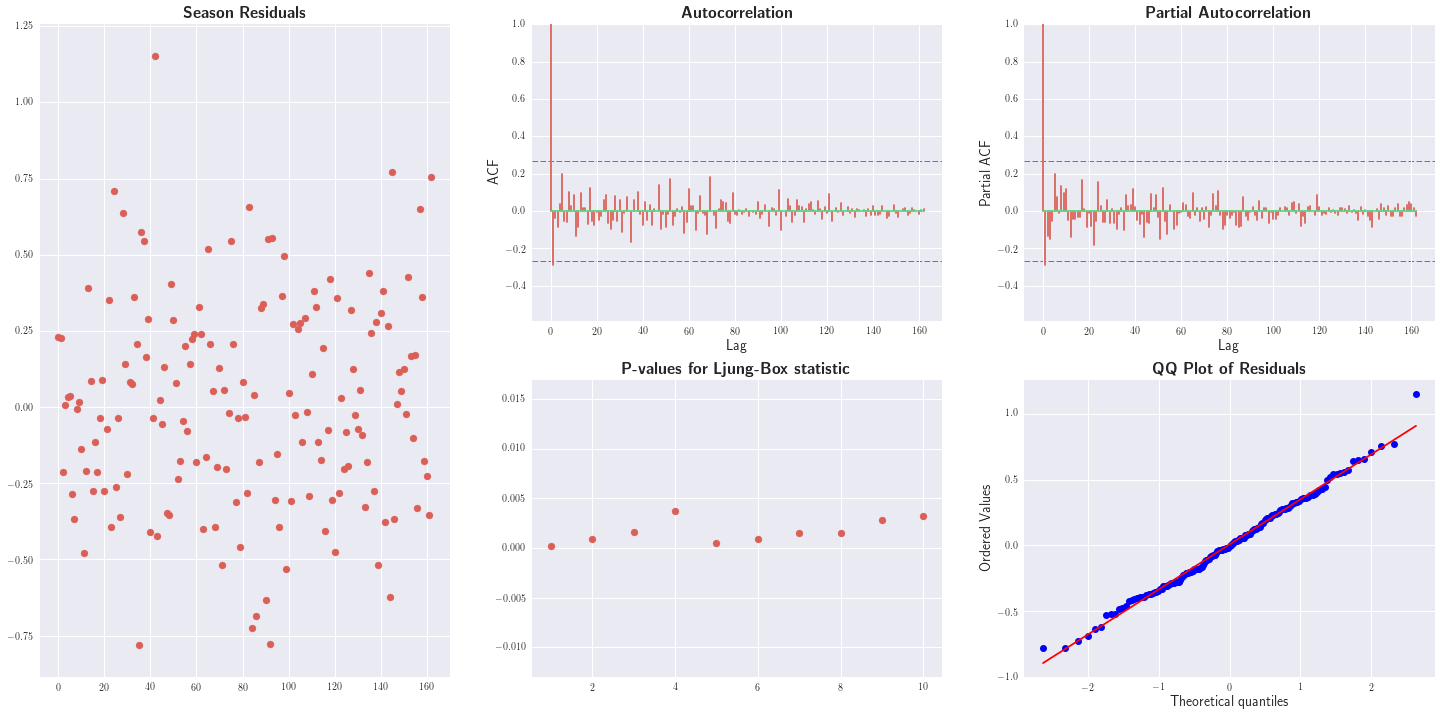

In [57]:
e_ar_jja = ts_diagnostics(fit_jja_ar2)

In [236]:
ks_results = scipy.stats.kstest(e_ar_jja, cdf='norm')
ks_results

KstestResult(statistic=0.26186030684621864, pvalue=2.374271890204227e-10)

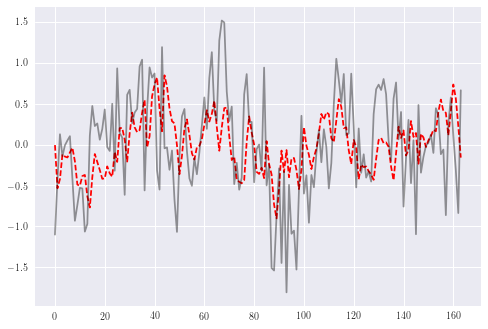

In [237]:
jja_predict = fit_jja_ar2.predict()

plt.plot(jja_predict, 'r--')
plt.plot(residuals['JJA'], color='k', alpha=0.4)

# SON

In [244]:
y_son = son_df.seaice_conc.values
sin_son = np.array([np.sin(2*np.pi*3 * (t/nyrs)) for t in np.arange(nyrs)])
cos_son = np.array([np.cos(2*np.pi*3 * (t/nyrs)) for t in np.arange(nyrs)])


In [245]:
fit_son = smf.glm(
    'y_son ~ sin_son + cos_son', data=son_df).fit()
fit_son.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  y_son   No. Observations:                  164
Model:                            GLM   Df Residuals:                      161
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                  0.582065832471
Method:                          IRLS   Log-Likelihood:                -186.82
Date:                Tue, 18 Jul 2017   Deviance:                       93.713
Time:                        06:29:28   Pearson chi2:                     93.7
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.1133      0.060    371.185      0.000      21.997      22.230
sin_son        0.3285      0.084      3.899      0.000       0.163       0.494
cos_son       -0.3014      0.084     -3.577      0.000      -0.467      -0.136
==============================================================================
"""

In [246]:
# Check pvalues for coefficients
fit_son.pvalues

Intercept    0.000000
sin_son      0.000097
cos_son      0.000347
dtype: float64

In [247]:
print(fit_son.params)
k_hat_son = fit_son.params.values  # extract fitted regression coefficients
e_son = fit_son.resid_response    # extract raw residuals

Intercept    22.113337
sin_son       0.328516
cos_son      -0.301392
dtype: float64


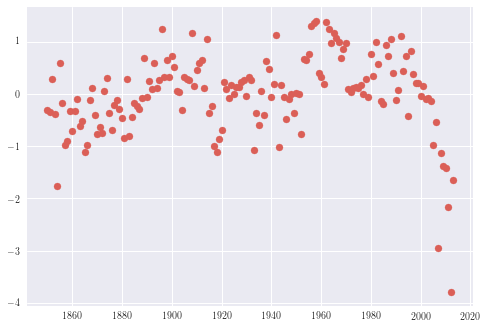

In [248]:
plt.scatter(son_df.year, e_son)

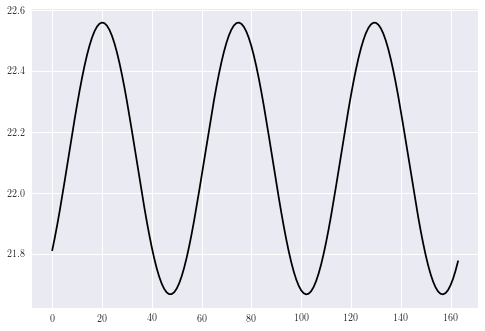

In [249]:
# fitted seasonal cycle
f_hat_son = k_hat_son[0] + k_hat_son[1]*sin_son + k_hat_son[2]*cos_son
plt.plot(f_hat_son,'k-')

In [250]:
# Remove residuals and subtract mean for second order residuals: R^2
resid2_son = residuals['SON'] - f_hat_son
resid2_son = resid2_son - np.mean(resid2_son)

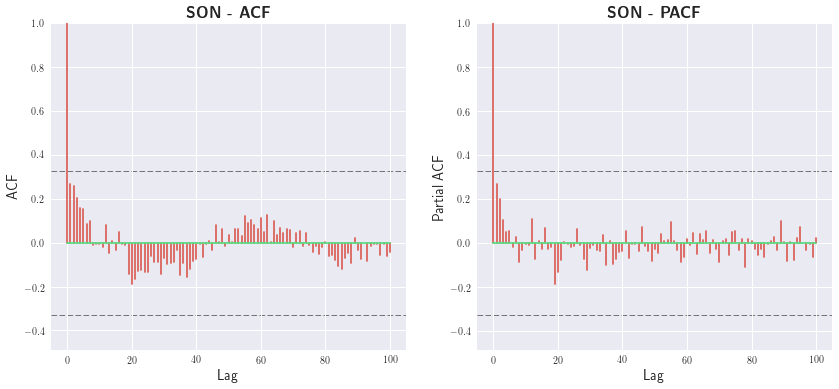

In [349]:
f, axs = plt.subplots(1, 2, figsize=(14,6))

plot_acf(resid2_son, nlags=100, ax=axs[0], title='SON - ACF')
plot_pacf(resid2_son, nlags=100, ax=axs[1], title='SON - PACF')

f.savefig('/home/hflores/repos/kaust_presentation/son_acf.eps', format='eps', 
          dpi=1200, bbox_inches='tight')

In [257]:
# Fit AR2 model for R^2
fit1_son = arima.ARIMA(resid2_son, (2,0,1)).fit()
fit2_son = arima.ARIMA(resid2_son, (2,0,0)).fit()
print(fit1_son.summary())
print(fit2_son.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(2, 1)   Log Likelihood                -127.259
Method:                       css-mle   S.D. of innovations              0.525
Date:                Tue, 18 Jul 2017   AIC                            264.517
Time:                        06:31:28   BIC                            280.017
Sample:                             0   HQIC                           270.809
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.087      0.105      0.916      -0.161       0.179
ar.L1.y        0.7100      0.234      3.034      0.003       0.251       1.169
ar.L2.y        0.0664      0.119      0.556      0.5

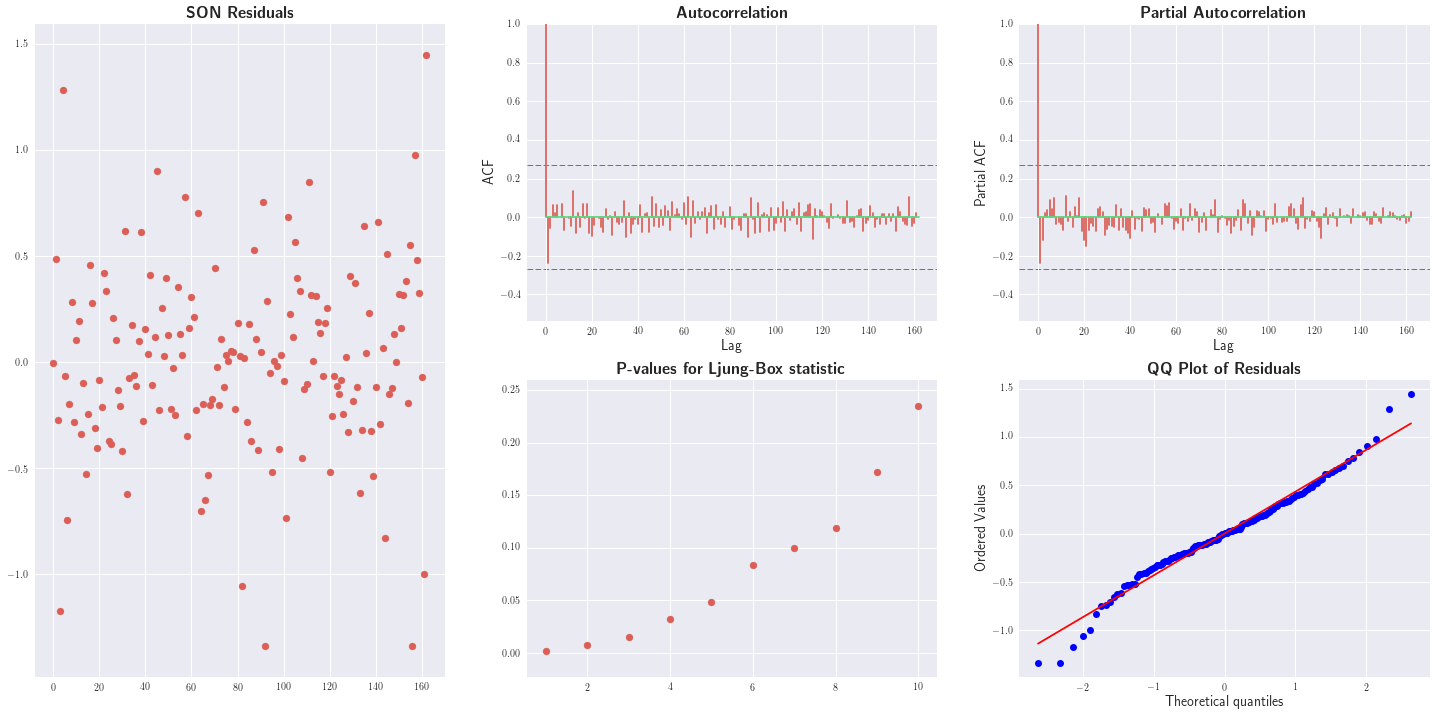

In [388]:
e_ar_son = ts_diagnostics(fit2_son)

In [261]:
ks_son = scipy.stats.kstest(e_ar_son, cdf='norm')
ks_son

KstestResult(statistic=0.22789717243215538, pvalue=6.3647236592245804e-08)

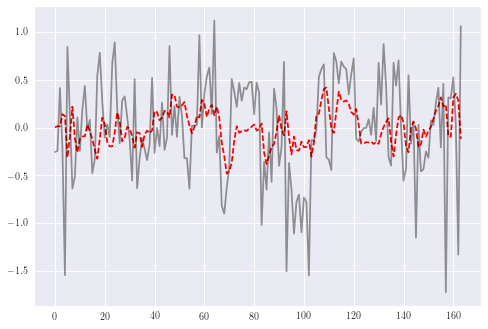

In [262]:
son_predict = fit2_son.predict()

plt.plot(son_predict, 'r--')
plt.plot(residuals['SON'], color='k', alpha=0.4)

# DJF

In [266]:
y_djf = djf_df.seaice_conc.values
sin1_djf = np.array([np.sin(2*np.pi*1 * (t/nyrs)) for t in np.arange(nyrs)])
cos1_djf = np.array([np.cos(2*np.pi*1 * (t/nyrs)) for t in np.arange(nyrs)])

sin2_djf = np.array([np.sin(2*np.pi*2 * (t/nyrs)) for t in np.arange(nyrs)])
cos2_djf = np.array([np.cos(2*np.pi*2 * (t/nyrs)) for t in np.arange(nyrs)])

sin4_djf = np.array([np.sin(2*np.pi*4 * (t/nyrs)) for t in np.arange(nyrs)])
cos4_djf = np.array([np.cos(2*np.pi*4 * (t/nyrs)) for t in np.arange(nyrs)])

sin8_djf = np.array([np.sin(2*np.pi*8 * (t/nyrs)) for t in np.arange(nyrs)])
cos8_djf = np.array([np.cos(2*np.pi*8 * (t/nyrs)) for t in np.arange(nyrs)])

sin9_djf = np.array([np.sin(2*np.pi*9 * (t/nyrs)) for t in np.arange(nyrs)])
cos9_djf = np.array([np.cos(2*np.pi*9 * (t/nyrs)) for t in np.arange(nyrs)])

sin11_djf = np.array([np.sin(2*np.pi*11 * (t/nyrs)) for t in np.arange(nyrs)])
cos11_djf = np.array([np.cos(2*np.pi*11 * (t/nyrs)) for t in np.arange(nyrs)])

In [267]:
fit_djf = smf.glm(
    'y_djf ~ sin1_djf + cos1_djf +\
    sin2_djf + cos2_djf +\
    sin4_djf + cos4_djf +\
    sin8_djf + cos8_djf +\
    sin9_djf + cos9_djf +\
    sin11_djf + cos11_djf', data=djf_df).fit()
fit_djf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  y_djf   No. Observations:                  164
Model:                            GLM   Df Residuals:                      151
Model Family:                Gaussian   Df Model:                           12
Link Function:               identity   Scale:                 0.0685487173298
Method:                          IRLS   Log-Likelihood:                -6.1566
Date:                Tue, 18 Jul 2017   Deviance:                       10.351
Time:                        06:39:41   Pearson chi2:                     10.4
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.5290      0.020   1346.522      0.000      27.489      27.569
sin1_djf      -0.0436      0.029     -1.507      0.132      -0.100       0.013
cos1_djf      -0.0214      0.029     -0.740      0.459      -0.078       0.035
sin2_djf      -0.0250      0.029     -0.865      0.387      -0.082       0.032
cos2_djf      -0.1172      0.029     -4.053      0.000      -0.174      -0.061
sin4_djf       0.1310      0.029      4.530      0.000       0.074       0.188
cos4_djf      -0.1083      0.029     -3.747      0.000      -0.165      -0.052
sin8_djf       0.0303      0.029      1.050      0.294      -0.026       0.087
cos8_djf      -0.0581      0.029     -2.010      0.044      -0.115      -0.001
sin9_djf       0.0599      0.029      2.073      0.038       0.003       0.117
cos9_djf       0.0566      0.029      1.959      0.050   -3.67e-05       0.113
sin11_djf      0.0066      0.029      0.229      0.819      -0.050       0.063
cos11_djf      0.0723      0.029      2.500      0.012       0.016       0.129
==============================================================================
"""

In [268]:
# Check pvalues for coefficients
fit_djf.pvalues

Intercept    0.000000
sin1_djf     0.131749
cos1_djf     0.459466
sin2_djf     0.386922
cos2_djf     0.000051
sin4_djf     0.000006
cos4_djf     0.000179
sin8_djf     0.293856
cos8_djf     0.044475
sin9_djf     0.038172
cos9_djf     0.050149
sin11_djf    0.818612
cos11_djf    0.012408
dtype: float64

In [270]:
print(fit_djf.params)
k_hat_djf = fit_djf.params.values  # extract fitted regression coefficients
e_djf = fit_djf.resid_response    # extract raw residuals

Intercept    27.529046
sin1_djf     -0.043579
cos1_djf     -0.021388
sin2_djf     -0.025016
cos2_djf     -0.117181
sin4_djf      0.130980
cos4_djf     -0.108344
sin8_djf      0.030350
cos8_djf     -0.058103
sin9_djf      0.059937
cos9_djf      0.056632
sin11_djf     0.006631
cos11_djf     0.072292
dtype: float64


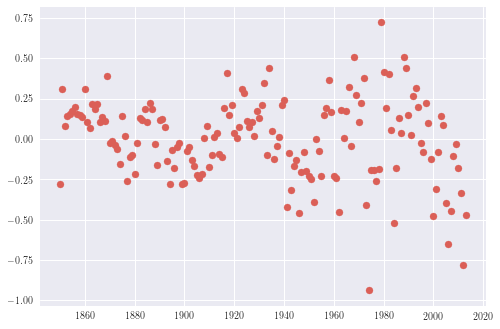

In [271]:
plt.scatter(djf_df.year, e_djf)

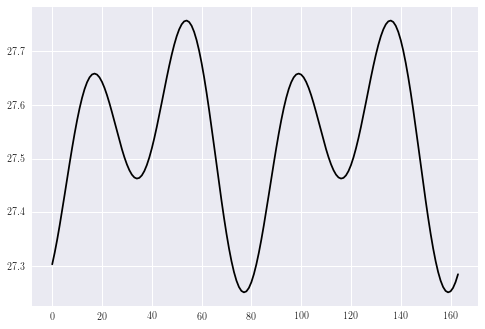

In [292]:
# fitted seasonal cycle
#+ k_hat_djf[8]*cos8_djf +\
f_hat_djf = k_hat_djf[0] + k_hat_djf[4]*cos2_djf +\
            k_hat_djf[5]*sin4_djf +k_hat_djf[6]*cos4_djf
plt.plot(f_hat_djf,'k-')

In [293]:
# Remove residuals and subtract mean for second order residuals: R^2
resid2_djf = residuals['DJF'] - f_hat_djf
resid2_djf = resid2_djf - np.mean(resid2_djf)

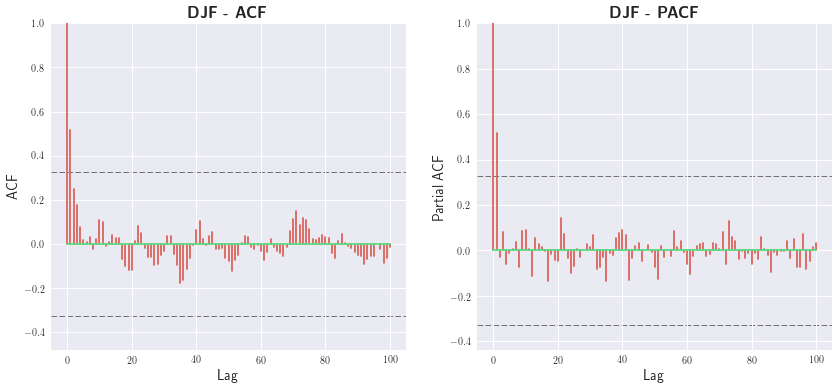

In [352]:
f, axs = plt.subplots(1, 2, figsize=(14,6))

plot_acf(resid2_djf, nlags=100, ax=axs[0], title='DJF - ACF')
plot_pacf(resid2_djf, nlags=100, ax=axs[1], title='DJF - PACF')

f.savefig('/home/hflores/repos/kaust_presentation/djf_acf.eps', format='eps', 
          dpi=1200, bbox_inches='tight')

In [294]:
# Fit AR2 model for R^2
fit1_djf = arima.ARIMA(resid2_djf, (1,0,0)).fit()
fit2_djf = arima.ARIMA(resid2_djf, (2,0,0)).fit()
print(fit1_djf.summary())
print(fit2_djf.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(1, 0)   Log Likelihood                  15.959
Method:                       css-mle   S.D. of innovations              0.219
Date:                Tue, 18 Jul 2017   AIC                            -25.918
Time:                        06:53:00   BIC                            -16.618
Sample:                             0   HQIC                           -22.142
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.036      0.054      0.957      -0.069       0.073
ar.L1.y        0.5285      0.067      7.897      0.000       0.397       0.660
                                    Roots           

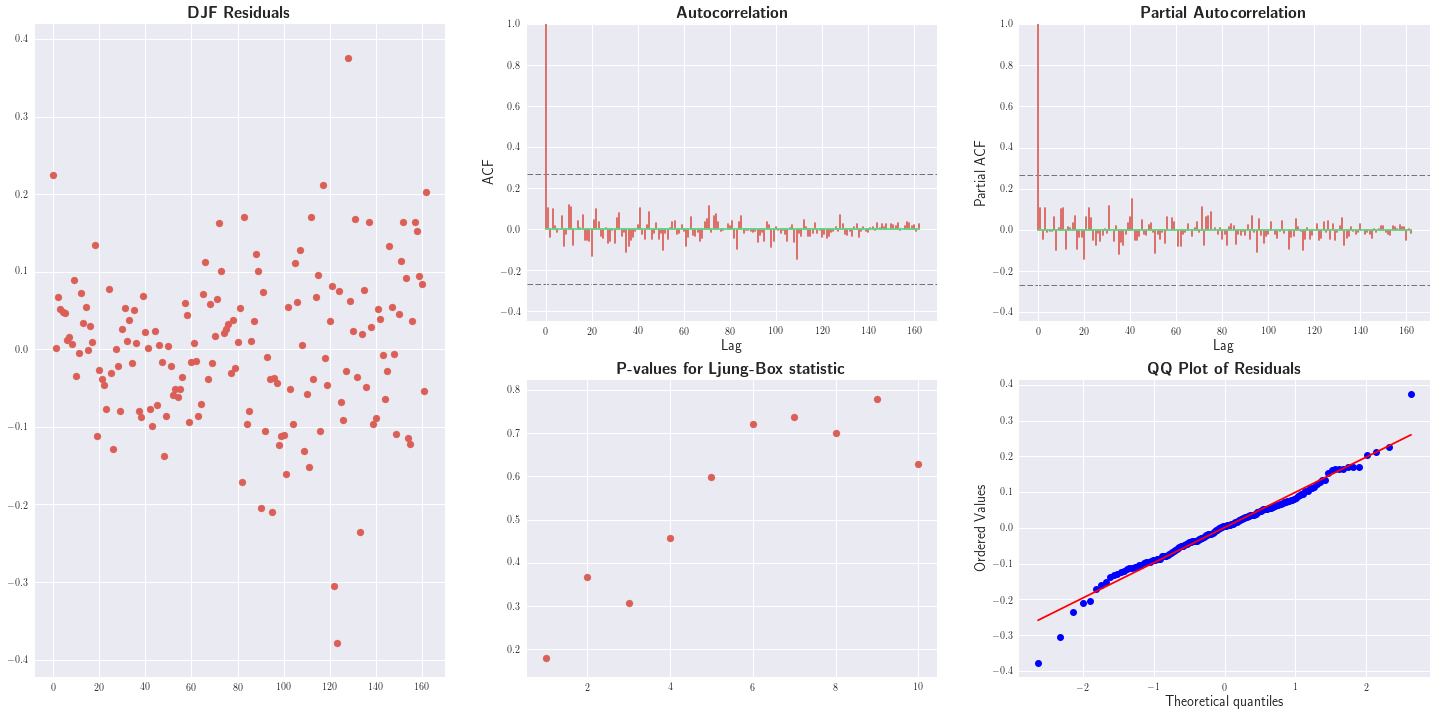

In [393]:
e_ar_djf = ts_diagnostics(fit2_djf, title='DJF')
#e_ar_djf = ts_diagnostics(fit2_djf, title='DJF', save='djf_res')

In [296]:
ks_djf = scipy.stats.kstest(e_ar_djf, cdf='norm')
ks_djf

KstestResult(statistic=0.40746726642974429, pvalue=0.0)

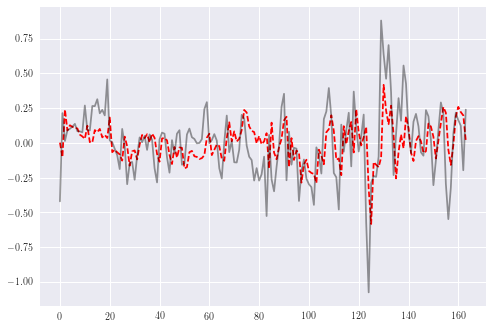

In [297]:
djf_predict = fit2_djf.predict()

plt.plot(djf_predict, 'r--')
plt.plot(residuals['DJF'], color='k', alpha=0.4)

# MAM

In [329]:
y_mam = mam_df.seaice_conc.values
sin2_mam = np.array([np.sin(2*np.pi * 2 * (t/nyrs)) for t in np.arange(nyrs)])
cos2_mam = np.array([np.cos(2*np.pi * 2 * (t/nyrs)) for t in np.arange(nyrs)])

sin13_mam = np.array([np.sin(2*np.pi * 13 * (t/nyrs)) for t in np.arange(nyrs)])
cos13_mam = np.array([np.cos(2*np.pi * 13 * (t/nyrs)) for t in np.arange(nyrs)])

In [330]:
fit_mam = smf.glm(
    'y_mam ~ sin2_mam + cos2_mam + sin13_mam + cos13_mam', data=mam_df).fit()
fit_mam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  y_mam   No. Observations:                  164
Model:                            GLM   Df Residuals:                      159
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                  0.133622288491
Method:                          IRLS   Log-Likelihood:                -65.122
Date:                Tue, 18 Jul 2017   Deviance:                       21.246
Time:                        07:38:03   Pearson chi2:                     21.2
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.6198      0.029    967.615      0.000      27.564      27.676
sin2_mam       0.0907      0.040      2.247      0.025       0.012       0.170
cos2_mam      -0.3030      0.040     -7.506      0.000      -0.382      -0.224
sin13_mam      0.1019      0.040      2.525      0.012       0.023       0.181
cos13_mam     -0.0148      0.040     -0.365      0.715      -0.094       0.064
==============================================================================
"""

In [331]:
# Check pvalues for coefficients
fit_mam.pvalues

Intercept    0.000000e+00
sin2_mam     2.467082e-02
cos2_mam     6.095577e-14
sin13_mam    1.158109e-02
cos13_mam    7.148003e-01
dtype: float64

In [332]:
print(fit_mam.params)
k_hat_mam = fit_mam.params.values  # extract fitted regression coefficients
e_mam = fit_mam.resid_response    # extract raw residuals

Intercept    27.619764
sin2_mam      0.090686
cos2_mam     -0.302999
sin13_mam     0.101914
cos13_mam    -0.014751
dtype: float64


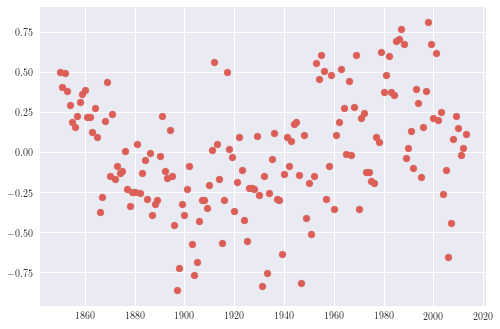

In [333]:
plt.scatter(mam_df.year, e_mam)

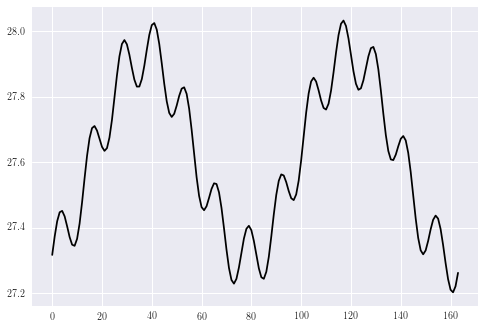

In [335]:
# fitted seasonal cycle
f_hat_mam = k_hat_mam[0] + k_hat_mam[1]*sin2_mam + k_hat_mam[2]*cos2_mam +\
            k_hat_mam[3]*sin13_mam
plt.plot(f_hat_mam,'k-')

In [336]:
# Remove residuals and subtract mean for second order residuals: R^2
resid2_mam = residuals['MAM'] - f_hat_mam
resid2_mam = resid2_mam - np.mean(resid2_mam)

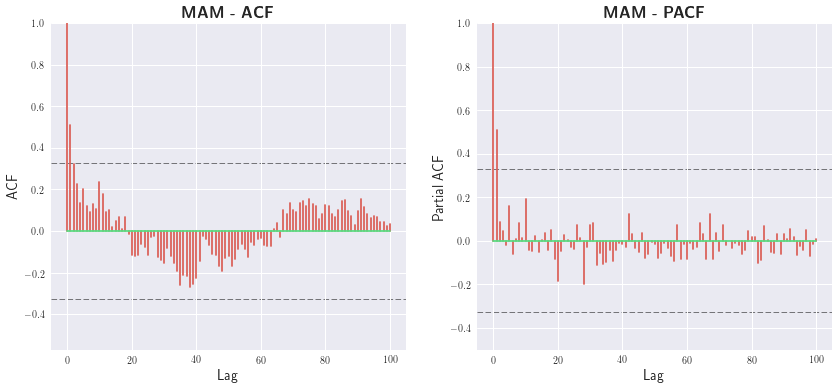

In [354]:
f, axs = plt.subplots(1, 2, figsize=(14,6))

plot_acf(resid2_mam, nlags=100, ax=axs[0], title='MAM - ACF')
plot_pacf(resid2_mam, nlags=100, ax=axs[1], title='MAM - PACF')

f.savefig('/home/hflores/repos/kaust_presentation/mam_acf.eps', format='eps', 
          dpi=1200, bbox_inches='tight')

In [337]:
# Fit AR2 model for R^2
fit2_mam = arima.ARIMA(resid2_mam, (2,0,0)).fit()
fit2_mam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(2, 0)   Log Likelihood                 -29.388
Method:                       css-mle   S.D. of innovations              0.289
Date:                Tue, 18 Jul 2017   AIC                             66.777
Time:                        07:39:38   BIC                             79.176
Sample:                             0   HQIC                            71.811
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.051      0.133      0.894      -0.094       0.107
ar.L1.y        0.4719      0.078      6.065      0.000       0.319       0.624
ar.L2.y        0.0907      0.078      1.161      0.247      -0.062       0.244
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6167           +0.0000j            1.6167            0.0000
AR.2           -6.8177           +0.0000j            6.8177            0.5000
-----------------------------------------------------------------------------
"""

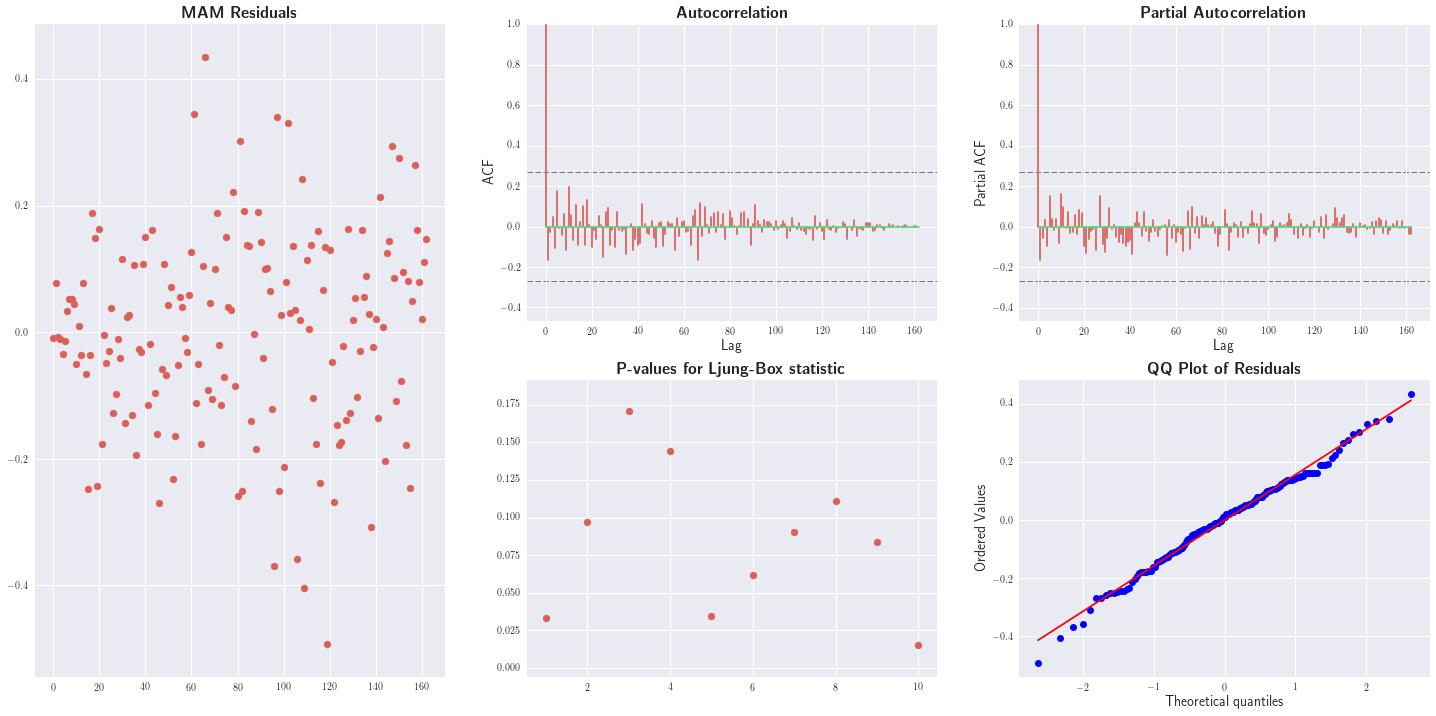

In [394]:
#e_mam = ts_diagnostics(fit2_mam, title='MAM')
e_mam = ts_diagnostics(fit2_mam, title='MAM', save='mam_res')

In [339]:
ks_mam = scipy.stats.kstest(e_ar_djf, cdf='norm')
ks_mam

KstestResult(statistic=0.40746726642974429, pvalue=0.0)

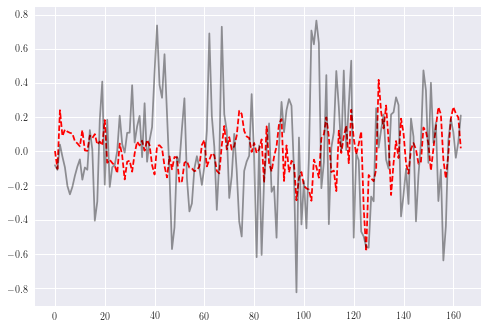

In [340]:
mam_predict = fit2_djf.predict()

plt.plot(mam_predict, 'r--')
plt.plot(residuals['MAM'], color='k', alpha=0.4)